### Imports

In [20]:
%load_ext autoreload
%autoreload 2

from fermionic_mappings import jw_majoranas, bk_majoranas
from electronic_hamiltonian import quadratic_terms, quartic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
from cost_functions import weight, quadratic_term_mean_weight, quartic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create Majorana Strings using Jordan-Wigner-Mapping or Bravyi-Kitaev-Mapping

In [29]:
N = 40

# x, z = jw_majoranas(N)
x, z, paulis = bk_majoranas(N)

# paulis = PauliList.from_symplectic(z, x)

print("Majorana Operators:", paulis)

Majorana Operators: ['IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXIXX',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXIXY',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXIXZ',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXIYI',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXXZI',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXYZI',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIXZZI',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIIIYIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIXXZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIXYZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIXZZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXIYIZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXXZIZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXYZIZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIXZZIZIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIIIIIYIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXIXXZIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXIXYZIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXIXZZIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXIYIZIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXXZIZIIIIIII',
 'IIIIIIIIXIIIIIIIIIIIIIIIXIIIXYZIZ

### (Optional) Compute all possible quadratic and quartic terms

In [29]:
x_terms, z_terms = quadratic_terms(x, z, N)
quadratic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quadratic Hamiltonian Terms:", quadratic_terms_paulis)

x_terms, z_terms = quartic_terms(x, z, N)
quartic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quartic Hamiltonian Terms:", quartic_terms_paulis)

print(f"Average Weight: {weight(x, z)}")

Quadratic Hamiltonian Terms: ['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIY',
 'IIIIIIIIIIIIIIIIIIIIIIIZX', 'IIIIIIIIIIIIIIIIIIIIIIXYX',
 'IIIIIIIIIIIIIIIIIIIIIIYYX', 'IIIIIIIIIIIIIIIIIIIIIIZYX',
 'IIIIIIIIIIIIIIIIIIIIIZIXX', 'IIIIIIIIIIIIIIIIIIIXXYIXX',
 'IIIIIIIIIIIIIIIIIIIXYYIXX', 'IIIIIIIIIIIIIIIIIIIXZYIXX',
 'IIIIIIIIIIIIIIIIIIIYIYIXX', 'IIIIIIIIIIIIIIIIIIXZIYIXX',
 'IIIIIIIIIIIIIIIIIIYZIYIXX', 'IIIIIIIIIIIIIIIIIIZZIYIXX',
 'IIIIIIIIIIIIIIIIIZIIIXIXX', 'IIIIIIIIIIIIIXIXXYIIIXIXX',
 'IIIIIIIIIIIIIXIXYYIIIXIXX', 'IIIIIIIIIIIIIXIXZYIIIXIXX',
 'IIIIIIIIIIIIIXIYIYIIIXIXX', 'IIIIIIIIIIIIIXXZIYIIIXIXX',
 'IIIIIIIIIIIIIXYZIYIIIXIXX', 'IIIIIIIIIIIIIXZZIYIIIXIXX',
 'IIIIIIIIIIIIIYIIIYIIIXIXX', 'IIIIIIIIIIIXXZIIIYIIIXIXX',
 'IIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIZY',
 'IIIIIIIIIIIIIIIIIIIIIIXYY', 'IIIIIIIIIIIIIIIIIIIIIIYYY',
 'IIIIIIIIIIIIIIIIIIIIIIZYY', 'IIIIIIIIIIIIIIIIIIIIIZIXY',
 'IIIIIIIIIIIIIIIIIIIXXYIXY', 'IIIIIIIIIIIIIIIIIIIXYYIXY',
 'IIIIIIIIIIIIIIIIIIIXZYIXY

### Simulated Annealing

Weight before: 8.951504540978226
Weight before: 8.36931830616041


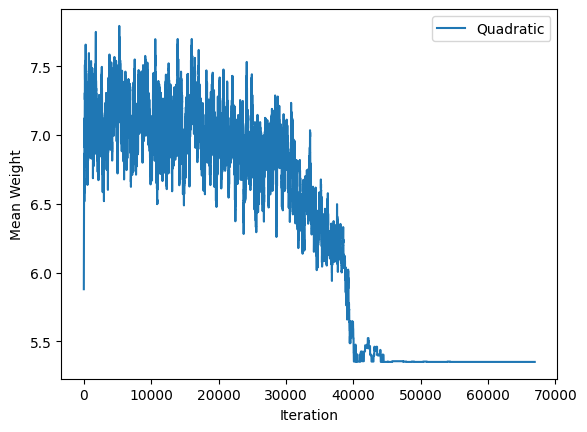

In [30]:
print("Weight before:", quartic_term_mean_weight(x, z))

x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9999)
# paulis = PauliList.from_symplectic(z, x)

print("Weight before:", quartic_term_mean_weight(x, z))

plt.plot(energies, label="Quadratic")

#x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quartic_term_mean_weight, cooling_rate=0.9995)
#paulis = PauliList.from_symplectic(z, x)
#
#plt.plot(energies, label="Quartic")

plt.xlabel("Iteration")
plt.ylabel("Mean Weight")
plt.legend()

### Locality Analysis starting from JW mapping

In [43]:
quadratic_weights = []
quartic_weights = []

num_qubits = list(range(10, 161, 10))

for N in num_qubits:

    x, z = jw_majoranas(N)
    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9995)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

T0 = 20
T0 = 40
T0 = 60
T0 = 80
T0 = 100
T0 = 120
T0 = 140
T0 = 160
T0 = 180
T0 = 200
T0 = 220
T0 = 240
T0 = 260
T0 = 280
T0 = 300
T0 = 320


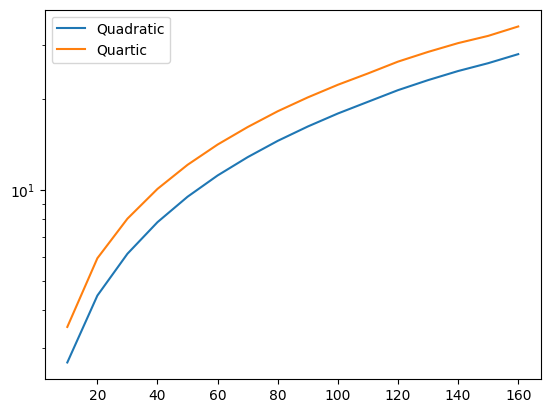

In [44]:
plt.plot(num_qubits, quadratic_weights, label="Quadratic")
plt.plot(num_qubits, quartic_weights, label="Quartic")
plt.yscale("log")
plt.legend()

In [ ]:
print(num_qubits)
print(quadratic_weights)
print(quartic_weights)

In [ ]:
### Storing the results here for the optimizations based on JW

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
[2.688888888888889, 4.473684210526316, 6.149425287356322, 7.82051282051282, 9.489795918367347, 11.158192090395481, 12.826086956521738, 14.518670886075949, 16.194007490636704, 17.87757575757576, 19.54095079232694, 21.351960784313725, 23.044722719141323, 24.697225077081193, 26.215928411633108, 28.083490566037735]
[3.5238095238095237, 5.943034055727554, 8.030140485312899, 10.073180873180872, 12.098827616152844, 14.115848944394886, 16.1279688513952, 18.187037645898407, 20.208548875034733, 22.245547246077436, 24.24570007716711, 26.528682207346215, 28.563445339681376, 30.543116705801157, 32.26899230143717, 34.66383368904967]

### Locality Analysis starting from BK mapping

In [17]:
quadratic_weights = []
quartic_weights = []

num_qubits = list(range(10, 61, 10))

for N in num_qubits:

    x, z, _ = bk_majoranas(N)
    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9999)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

T0 = 1.3010299956639813
T0 = 1.6020599913279623
T0 = 1.7781512503836436
T0 = 1.9030899869919435
T0 = 2.0
T0 = 2.0791812460476247


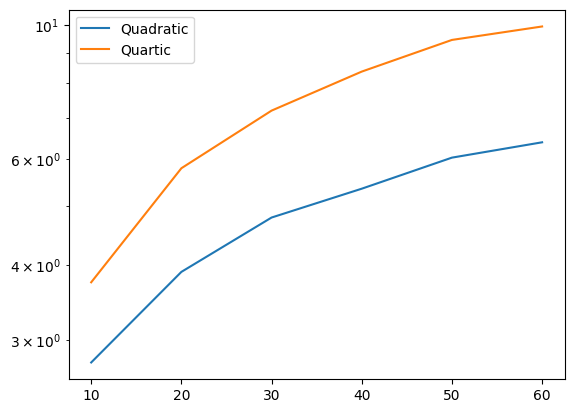

In [18]:
plt.plot(num_qubits, quadratic_weights, label="Quadratic")
plt.plot(num_qubits, quartic_weights, label="Quartic")
plt.yscale("log")
plt.legend()

### Comparison between BK and post-BK solution

In [27]:
quadratic_weights = []
quartic_weights = []

quadratic_weights_bk = []
quartic_weights_bk = []

num_qubits = list(range(10, 81, 10))

for N in num_qubits:

    x, z, _ = bk_majoranas(N)

    quadratic_weights_bk.append(quadratic_term_mean_weight(x, z))
    quartic_weights_bk.append(quartic_term_mean_weight(x, z))

    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9999)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

quadratic_ratios = np.array(quadratic_weights) / np.array(quadratic_weights_bk)
quartic_ratios = np.array(quartic_weights) / np.array(quartic_weights_bk)

T0 = 1.3010299956639813
T0 = 1.6020599913279623
T0 = 1.7781512503836436
T0 = 1.9030899869919435
T0 = 2.0
T0 = 2.0791812460476247
T0 = 2.146128035678238
T0 = 2.2041199826559246


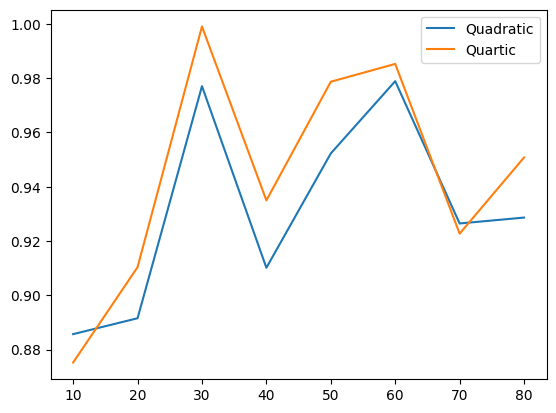

In [28]:
plt.plot(num_qubits, quadratic_ratios, label="Quadratic")
plt.plot(num_qubits, quartic_ratios, label="Quartic")
plt.legend()

### Locality Analysis of BK mapping

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


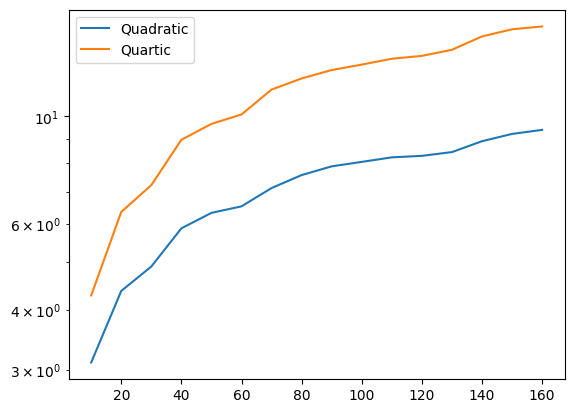

In [ ]:
from qiskit_nature.second_q.mappers.bravyi_kitaev_mapper import BravyiKitaevMapper
from itertools import chain

quadratic_weights = []
quartic_weights = []

num_qubits = list(range(10, 201, 10))

for N in num_qubits:

    x, z, _ = bk_majoranas(N)

    quadratic_weights.append(quadratic_term_mean_weight(x, z))
    quartic_weights.append(quartic_term_mean_weight(x, z))

plt.plot(num_qubits, quadratic_weights, label="Quadratic")
plt.plot(num_qubits, quartic_weights, label="Quartic")
plt.yscale("log")
plt.legend()